In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes
from torchvision.ops import box_convert
from torch.utils.data import TensorDataset


from project_functions import *
from project_objects import *
from project_models import *
from project_constants import DEVICE as device
from project_constants import SEED

In [2]:
torch.manual_seed(SEED)
torch.set_default_dtype(torch.double)

## 2 Object Localization
#### First we load and inspect the localization datasets

In [3]:
loc_train = torch.load('data/localization_train.pt')
loc_val = torch.load('data/localization_val.pt')
loc_test = torch.load('data/localization_test.pt')

In [4]:
print(f'Train data size: {len(loc_train)}')
print(f'Val data size: {len(loc_val)}')
print(f'Test data size: {len(loc_test)}')

Train data size: 59400
Val data size: 6600
Test data size: 11000


In [5]:
first_img, first_label = loc_train[0]

print(f'Shape of first image: {first_img.shape}')
print(f'Type of first image: {type(first_img)}')

print(f'\nShape of first label: {first_label.shape}')
print(f'Type of first label: {type(first_label)})')
first_label

Shape of first image: torch.Size([1, 48, 60])
Type of first image: <class 'torch.Tensor'>

Shape of first label: torch.Size([6])
Type of first label: <class 'torch.Tensor'>)


tensor([1.0000, 0.6000, 0.2292, 0.3667, 0.4167, 4.0000], dtype=torch.float32)

In [6]:
# Assuming train_data, val_data, and test_data are defined elsewhere
count_instances(loc_train, 'Training Data')
count_instances(loc_val, 'Validation Data')
count_instances(loc_test, 'Test Data')


Class distribution in Training Data
0: 5345
1: 6075
2: 5365
3: 5522
4: 5243
5: 4889
6: 5310
7: 5644
8: 5249
9: 5358
99: 5400
Class distribution in Validation Data
0: 578
1: 667
2: 593
3: 609
4: 599
5: 532
6: 608
7: 621
8: 602
9: 591
99: 600
Class distribution in Test Data
0: 980
1: 1135
2: 1032
3: 1010
4: 982
5: 892
6: 958
7: 1028
8: 974
9: 1009
99: 1000


#### Plotting one image from each class

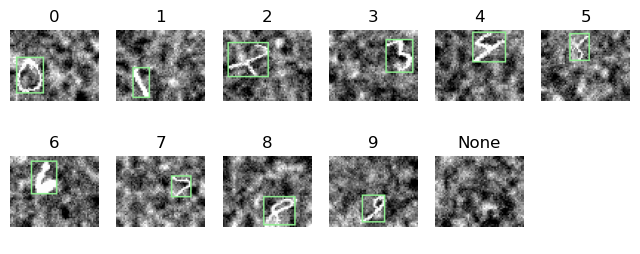

In [7]:
plot_localization_data(loc_train)

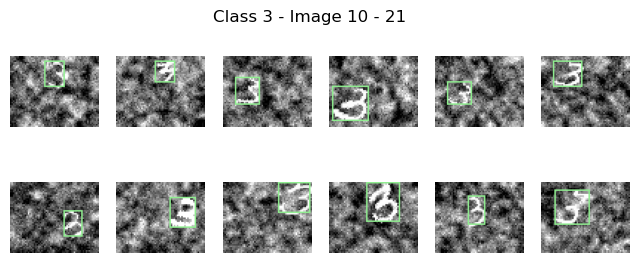

In [8]:
plot_localization_data(loc_train, class_label=3, start_idx=10)

#### Defining a normalizer and a preprocessor

In [9]:
# imgs = torch.stack([img for img, _ in loc_train])

# # Define normalizer
# normalizer_pipe = transforms.Normalize(
#     imgs.mean(dim=(0, 2, 3)), 
#     imgs.std(dim=(0, 2, 3))
#     )

# # Define preprocessor including the normalizer
# preprocessor = transforms.Compose([
#             normalizer_pipe
#         ])

In [10]:
# loc_train_norm = [(preprocessor(img), label) for img, label in loc_train]
# loc_val_norm = [(preprocessor(img), label) for img, label in loc_val]
# loc_test_norm = [(preprocessor(img), label) for img, label in loc_test]

loc_train_norm, loc_val_norm, loc_test_norm = normalizer(loc_train, loc_val, loc_test)

In [11]:
train_loader = torch.utils.data.DataLoader(loc_train_norm, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(loc_val_norm, batch_size=64, shuffle=False)

loss_fn = LocalizationLoss()

#### Defining models

12:17:23  |  Epoch 1  |  Training loss 2.352
12:17:23  |  Epoch 1  |  Validation loss 1.974
Estimated time left: 1m 27s
12:17:45  |  Epoch 2  |  Training loss 1.714
12:17:45  |  Epoch 2  |  Validation loss 1.189
Estimated time left: 1m 5s
12:18:06  |  Epoch 3  |  Training loss 0.677
12:18:06  |  Epoch 3  |  Validation loss 0.567
Estimated time left: 0m 43s
12:18:28  |  Epoch 4  |  Training loss 0.368
12:18:28  |  Epoch 4  |  Validation loss 0.381
Estimated time left: 0m 22s
12:18:50  |  Epoch 5  |  Training loss 0.263
12:18:50  |  Epoch 5  |  Validation loss 0.280
Estimated time left: 0m 0s
Training performance: [tensor(0.9414, device='cuda:0'), 0.4603887139561175, tensor(0.7009, device='cuda:0')]
Validation performance:[tensor(0.9215, device='cuda:0'), 0.4601801258326371, tensor(0.6908, device='cuda:0')]


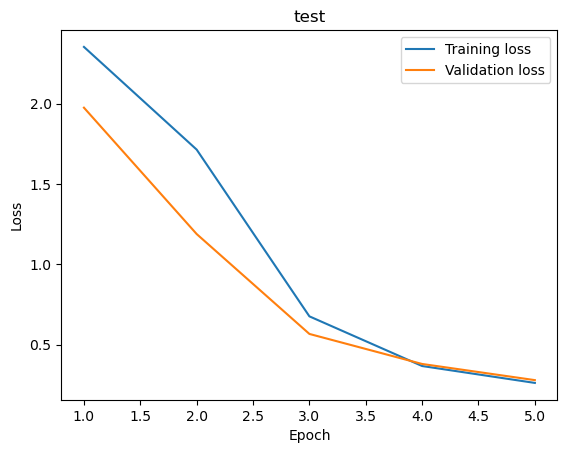

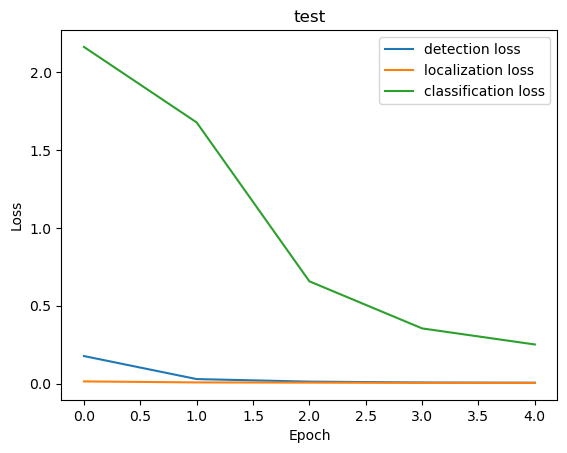

In [12]:
model_name = 'test'

torch.manual_seed(SEED)
model = LocCNN2((48,60,1))
model.to(device=device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.001)

loss_train, loss_val, train_perform, val_perform, losses_separated = train(
    n_epochs=5,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
    val_loader=val_loader,
    performance_calculator=localization_performance
)

plot_loss(loss_train, loss_val, model_name, save_model=True)
plot_lists(losses_separated, ['detection loss', 'localization loss', 'classification loss'], model_name, save_model=False)
y_true, y_pred = predict(model, val_loader)

#### Selecting the best model

In [13]:
best_model, best_performance = model_selector([model], [val_perform[2]])

# Print additional details of the best model
print("Best Model Details\n--------------------------------------------------------------")
print(f"Network architecture/ layout: {best_model}\n")
#print(f"Optimizer Parameters: {best_data.optimizer")
print(f"Validation Performance: {best_performance}")
#print(f"Validation Accuracy {round(best_data['model_man_val_accuracy'], 2)}")

Best Model Details
--------------------------------------------------------------
Network architecture/ layout: LocCNN2(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 2), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=384, out_features=100, bias=True)
  (fc2): L

#### Evaluating the best model on unseen data TBD

In [14]:
test_loader = torch.utils.data.DataLoader(loc_test_norm, batch_size=64, shuffle=False)

test_performance = localization_performance(best_model, test_loader)
print(10*'-'+'Test Performance' + 10*'-')
print(f"Test Accuracy: {test_performance[0]}\nTest IOU: {test_performance[1]}\nOverall Performance: {test_performance[2]}")

----------Test Performance----------
Test Accuracy: 0.9316363636363636
Test IOU: 0.4593362265467629
Overall Performance: 0.6954862950915632


In [15]:
y_true, y_pred = predict(best_model, test_loader)

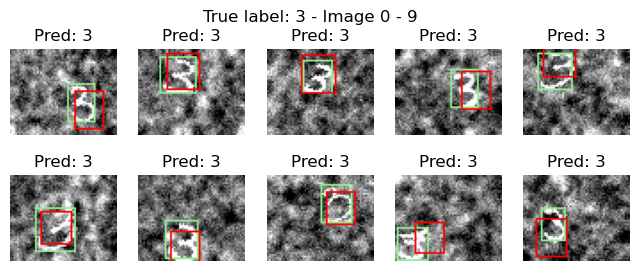

In [16]:
plot_predictions(loc_test, y_true, y_pred, label=3, start_idx=0)

# 3 Object Detection

#### Loading the data and inspecting the data

In [17]:
import torch
import torch.nn as nn
from torchvision import transforms
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes
from torchvision.ops import box_convert
from torch.utils.data import TensorDataset


from project_functions import *
from project_objects import *
from project_models import *
from project_constants import DEVICE as device
from project_constants import SEED

torch.set_default_dtype(torch.double)

In [18]:
train_labels = torch.load('data/list_y_true_train.pt')
val_labels = torch.load('data/list_y_true_val.pt')
test_labels = torch.load('data/list_y_true_test.pt')

In [19]:
print(f'Train label size: {len(train_labels)}')
print(f'Val label size: {len(val_labels)}')
print(f'Test label size: {len(test_labels)}')

Train label size: 26874
Val label size: 2967
Test label size: 4981


In [20]:
train_imgs = torch.load('data/detection_train.pt')
val_imgs = torch.load('data/detection_val.pt')
test_imgs = torch.load('data/detection_test.pt')

In [21]:
train_labels_local = prepare_labels(train_labels, (2,3,6))
val_labels_local = prepare_labels(val_labels, (2,3,6))
test_labels_local = prepare_labels(test_labels, (2,3,6))

In [22]:
det_train = merge_datasets(train_imgs, train_labels_local)
det_val = merge_datasets(val_imgs, val_labels_local)
det_test = merge_datasets(test_imgs, test_labels_local)

#### Plotting some images from the detection dataset

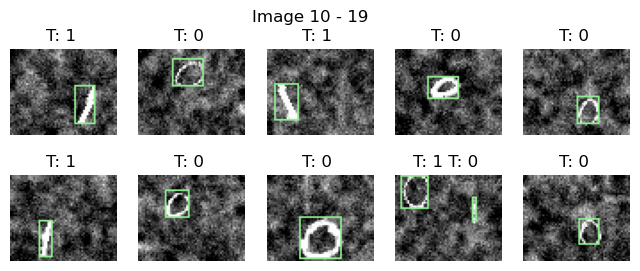

In [23]:
imgs = [img for img,_ in train_imgs]
plot_detection_data(imgs, train_labels, start_idx=10)

#### Normalizing the dataset TBD

In [24]:
train_loader = torch.utils.data.DataLoader(det_train, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(det_val, batch_size=64, shuffle=False)

loss_fn = DetectionLoss()

#### Defining models

In [25]:
model_name = 'test'
torch.manual_seed(SEED)
model = DetCNN1()
model.to(device=device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.001)

loss_train, loss_val, train_performance, val_performance, losses_separated= train(
    n_epochs=2,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
    val_loader=val_loader,
    performance_calculator=detection_performance
)

plot_loss(loss_train, loss_val, model_name, save_model=False)
plot_lists(losses_separated, ['detection loss', 'localization loss', 'classification loss'], model_name, save_model=False)

12:19:16  |  Epoch 1  |  Training loss 1.279
12:19:16  |  Epoch 1  |  Validation loss 1.244
Estimated time left: 0m 8s


KeyboardInterrupt: 

In [ ]:
y_true, y_pred = predict(model, val_loader)
imgs = [img for img,_ in val_imgs]
y_pred_reshaped = y_pred.permute(0,2,3,1)
y_pred_global = local_to_global_list(y_pred_reshaped)
plot_detection_data(imgs, val_labels, y_pred_global, start_idx=10)